# Introduction

The goal of this notebook is to predict the next-day maximum and minimum air temperature having the data from [UCI](https://archive.ics.uci.edu/ml/datasets/Bias+correction+of+numerical+prediction+model+temperature+forecast)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import keras

from keras import models
from keras import layers
from sklearn.model_selection import train_test_split

keras.__version__

'2.3.1'

In [18]:
# definition of functions used in the notebook
def build_model(units=64, extra_hidden_layers=0, activation='relu'):
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(units, activation=activation, input_shape=(x_train.shape[1],)))
    if extra_hidden_layers != 0:
        for i in range(extra_hidden_layers):
            units = units / 2
            model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(2))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


def normalize_data(x_train, x_test):
    mean = x_train.mean(axis=0)
    x_train -= mean
    std = x_train.std(axis=0)
    x_train /= std

    x_test -= mean
    x_test /= std
    return x_train, x_test


def train_and_evaluate_model(x_train, y_train, units=64, k=5, num_epochs=100, extra_hidden_layers=0, activation='relu', 
                            best_model_path='best_model.h5'):
    # define the callback to stop when there is no significant improvement in val_mae
    callbacks = [keras.callbacks.EarlyStopping(
        monitor="val_mae",
        min_delta=0.0001,
        patience=20,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
        ),
        keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_mae', mode='auto', save_best_only=True)
    ]
    k = 5
    num_val_samples = len(x_train) // k
    all_maes = []
    for i in range(k):
        print('processing fold #', i)
        # Prepare the validation data: data from partition # k
        val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate([x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], 
                                            axis=0)
        partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], 
                                               axis=0)

        # Build the Keras model
        model = build_model(units, extra_hidden_layers, activation)
    
        history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                            epochs=num_epochs, batch_size=1, verbose=1, callbacks=callbacks)
        # Evaluate the model on the validation data
        mae = history.history['val_mae']
        all_maes.append(mae)
    average_mae_history = [np.mean([x[i] for x in all_maes if i<len(x)]) for i in range(num_epochs)]
    return model, average_mae_history


def split_and_normalize(data):
    x = data.drop(['Next_Tmax', 'Next_Tmin'], axis=1)
    y = data[['Next_Tmax', 'Next_Tmin']]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train, x_test = normalize_data(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [19]:
data = pd.read_csv("Bias_correction_ucl.csv", parse_dates = ["Date"])
length_before = len(data)

## Data insights

### Basic stats

In [20]:
data.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7750.000000,7682.000000,7682.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,...,7677.000000,7677.000000,7677.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7725.000000,7725.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,...,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.211568,2.969999,2.413961,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,...,1.762807,1.161809,1.206214,0.050352,0.079435,54.279780,1.370444,429.158867,3.128010,2.487613
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,...,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


In [21]:
print(f'The data was acquired between {data.Date.min()} - {data.Date.max()}')

The data was acquired between 2013-06-30 00:00:00 - 2017-08-30 00:00:00


In [22]:
# replace the column with datetime by the day of the year
data['day_of_the_year'] = data.Date.apply(lambda x: x.month * 30 + x.day)
data.drop("Date", axis=1, inplace=True)

### NaN values
In this approach, the easiest solution is performed - the rows containing NaN values are simply dropped.

In [23]:
nans = data.isna().sum()
nans.index.name = "Column"
nans.name = "Number of NaN values"

In [24]:
nans.to_frame()

,Number of NaN values
Column,
station,2
Present_Tmax,70
Present_Tmin,70
LDAPS_RHmin,75
LDAPS_RHmax,75
LDAPS_Tmax_lapse,75
LDAPS_Tmin_lapse,75
LDAPS_WS,75
LDAPS_LH,75


In [25]:
data = data.dropna()

In [26]:
length_after = len(data)

In [27]:
print(f'Droppped {length_before - length_after} ({np.round((length_before - length_after) / length_before * 100, 2)}%) rows due to null values')

Droppped 164 (2.12%) rows due to null values


### Correlations between columns

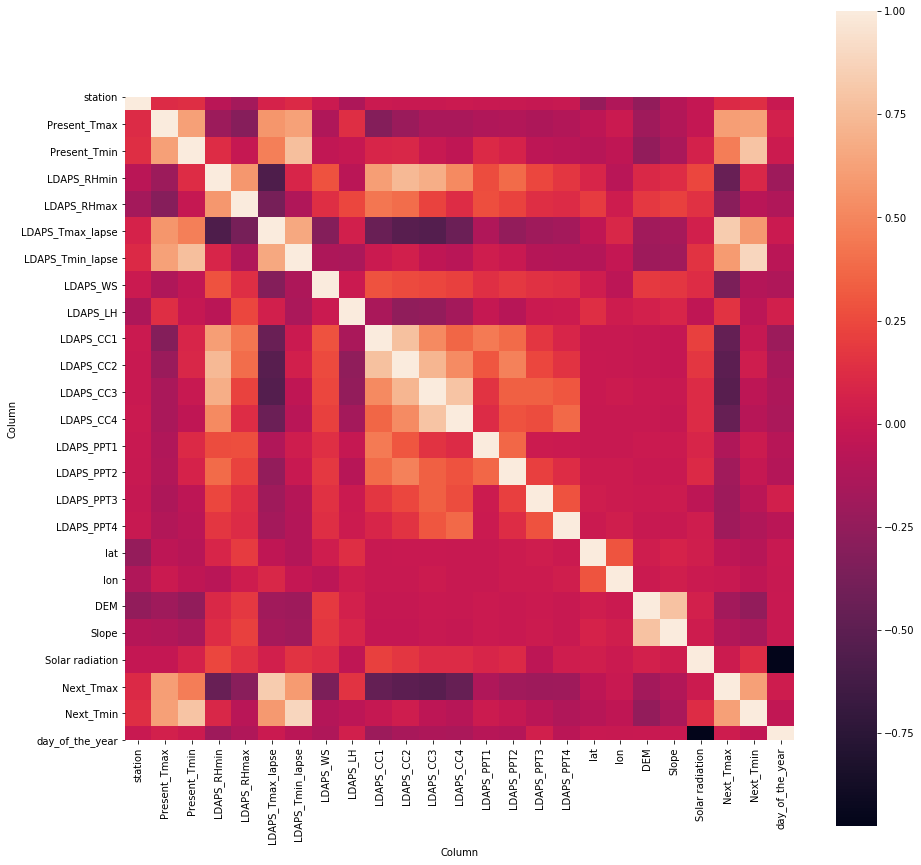

In [28]:
fig = plt.figure(figsize = (15,15))
corr = data.corr()
sb.heatmap(corr, square = True)

Conclusion: We keep all the features as they all seem to be correlated with target features

## The choice of the model

In [ ]:
x_train, x_test, y_train, y_test = split_and_normalize(data)
model_1, average_mae_history_1 = train_and_evaluate_model(x_train, y_train, units=64, k=5, num_epochs=100, 
                                                          extra_hidden_layers=0, activation='relu', 
                                                          best_model_path='model1.h5')
model_2, average_mae_history_2 = train_and_evaluate_model(x_train, y_train, units=32, k=5, num_epochs=100, 
                                                          extra_hidden_layers=0, activation='relu',
                                                          best_model_path='model2.h5')
model_3, average_mae_history_3 = train_and_evaluate_model(x_train, y_train, units=64, k=5, num_epochs=100, 
                                                          extra_hidden_layers=1, activation='relu', 
                                                          best_model_path='model3.h5')
model_4, average_mae_history_4 = train_and_evaluate_model(x_train, y_train, units=64, k=5, num_epochs=100, 
                                                          extra_hidden_layers=2, activation='relu', 
                                                          best_model_path='model4.h5')
model_5, average_mae_history_5 = train_and_evaluate_model(x_train, y_train, units=128, k=5, num_epochs=100, 
                                                          extra_hidden_layers=2, activation='relu', 
                                                          best_model_path='model5.h5')

processing fold # 0
Train on 4856 samples, validate on 1214 samples
Epoch 1/100
4856/4856 [==============================] - 7s 1ms/step - loss: 60.5814 - mae: 4.4742 - val_loss: 4.7990 - val_mae: 1.5690
Epoch 2/100
4856/4856 [==============================] - 7s 1ms/step - loss: 3.9893 - mae: 1.4166 - val_loss: 3.1225 - val_mae: 1.2385
Epoch 3/100
4856/4856 [==============================] - 6s 1ms/step - loss: 2.8476 - mae: 1.1961 - val_loss: 2.6974 - val_mae: 1.1506
Epoch 4/100
4856/4856 [==============================] - 6s 1ms/step - loss: 2.2619 - mae: 1.0942 - val_loss: 2.3917 - val_mae: 1.1348
Epoch 5/100
4856/4856 [==============================] - 6s 1ms/step - loss: 1.9650 - mae: 1.0412 - val_loss: 1.9382 - val_mae: 1.0215
Epoch 6/100
4856/4856 [==============================] - 7s 1ms/step - loss: 1.8046 - mae: 1.0010 - val_loss: 1.7297 - val_mae: 0.9824
Epoch 7/100
4856/4856 [==============================] - 7s 1ms/step - loss: 1.6812 - mae: 0.9641 - val_loss: 1.9346 - va

In [ ]:
fig = plt.figure(figsize = (15,15))
plt.plot(average_mae_history_1, color='red', label='Units: 64, hidden_layers: 1')
plt.plot(average_mae_history_2, color='blue', label='Units: 32, hidden_layers: 1')
plt.plot(average_mae_history_3, color='yellow', label='Units: 64, hidden_layers: 2')
plt.plot(average_mae_history_4, color='green', label='Units: 64, hidden_layers: 3')
plt.plot(average_mae_history_5, color='black', label='Units: 128, hidden_layers: 3')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [ ]:
model_1 = keras.models.load_model('model1.h5')
model_2 = keras.models.load_model('model2.h5')
model_3 = keras.models.load_model('model3.h5')
model_4 = keras.models.load_model('model4.h5')
model_5 = keras.models.load_model('model5.h5')

_, test_mae_score_1 = model_1.evaluate(x_test, y_test)
_, test_mae_score_2 = model_2.evaluate(x_test, y_test)
_, test_mae_score_3 = model_3.evaluate(x_test, y_test)
_, test_mae_score_4 = model_4.evaluate(x_test, y_test)
_, test_mae_score_5 = model_5.evaluate(x_test, y_test)

evaluations = pd.DataFrame(np.array([[test_mae_score_1, test_mae_score_2, test_mae_score_3, test_mae_score_4, 
                                      test_mae_score_5]]), 
                           columns=['U:64, HL:1', 'U:32, HL:1', 'U:64, HL:2', 'U:64, HL:3', 'U:128, HL:3'])

In [ ]:
evaluations